In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import logging
from pathlib import Path
from ordered_set import OrderedSet
from scipy.stats import chi2_contingency
import os
import mlflow
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    PowerTransformer,
    PolynomialFeatures,
    QuantileTransformer,
)
import warnings
warnings.filterwarnings('ignore')
root = Path("../")
artifacts = root / "artifacts"
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)
logger.info(f"artifacts folder is created at {artifacts}")
logger.info(f"files are stored at {artifacts} - {os.listdir(artifacts)}")

2024-07-13 20:59:05,302 - INFO - artifacts folder is created at ..\artifacts
2024-07-13 20:59:05,304 - INFO - files are stored at ..\artifacts - ['ds_salaries.csv']


In [5]:
dataset = pd.read_csv(artifacts / "ds_salaries.csv")
logger.info(f"dataset is read from {artifacts}")
dataset.head()

2024-07-13 20:56:40,357 - INFO - dataset is read from ..\artifacts


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


# Exploratory Data Analysis


## Data Cleaning

In [6]:
dataset.duplicated().sum()

1171

In [7]:
dataset = dataset.drop_duplicates()
dataset.shape

(2584, 11)

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           2584 non-null   int64 
 1   experience_level    2584 non-null   object
 2   employment_type     2584 non-null   object
 3   job_title           2584 non-null   object
 4   salary              2584 non-null   int64 
 5   salary_currency     2584 non-null   object
 6   salary_in_usd       2584 non-null   int64 
 7   employee_residence  2584 non-null   object
 8   remote_ratio        2584 non-null   int64 
 9   company_location    2584 non-null   object
 10  company_size        2584 non-null   object
dtypes: int64(4), object(7)
memory usage: 242.2+ KB


In [9]:
dataset.describe(include="all")

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,2584.000000,2584,2584,2584,2.584000e+03,2584,2584.000000,2584,2584.000000,2584,2584
unique,NaN,4,4,93,NaN,20,NaN,78,NaN,72,3
top,NaN,SE,FT,Data Engineer,NaN,USD,NaN,US,NaN,US,M
freq,NaN,1554,2547,598,NaN,2107,NaN,1893,NaN,1929,2028
mean,2022.301084,NaN,NaN,NaN,2.103653e+05,NaN,133409.280186,NaN,50.483746,NaN,NaN
std,0.749179,NaN,NaN,NaN,8.080375e+05,NaN,67136.837329,NaN,48.163707,NaN,NaN
min,2020.000000,NaN,NaN,NaN,6.000000e+03,NaN,5132.000000,NaN,0.000000,NaN,NaN
25%,2022.000000,NaN,NaN,NaN,9.000000e+04,NaN,84975.000000,NaN,0.000000,NaN,NaN
50%,2022.000000,NaN,NaN,NaN,1.346300e+05,NaN,130000.000000,NaN,50.000000,NaN,NaN
75%,2023.000000,NaN,NaN,NaN,1.825625e+05,NaN,175000.000000,NaN,100.000000,NaN,NaN


In [10]:
# correcting data types

cat_cols = [
    "work_year",
    "experience_level",
    "employment_type",
    "job_title",
    "salary_currency",
    "employee_residence",
    "company_location",
    "company_size",
    "remote_ratio"
]
num_cols = list(set(dataset.columns) - set(cat_cols + ["salary"]))

for col in cat_cols:
    dataset[col] = pd.Categorical(dataset[col])

for col in num_cols:
    dataset[col] = pd.to_numeric(dataset[col])

In [11]:
dataset.describe(include="all")

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,2584.0,2584,2584,2584,2.584000e+03,2584,2584.000000,2584,2584.0,2584,2584
unique,4.0,4,4,93,NaN,20,NaN,78,3.0,72,3
top,2023.0,SE,FT,Data Engineer,NaN,USD,NaN,US,100.0,US,M
freq,1156.0,1554,2547,598,NaN,2107,NaN,1893,1211.0,1929,2028
mean,NaN,NaN,NaN,NaN,2.103653e+05,NaN,133409.280186,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,8.080375e+05,NaN,67136.837329,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,6.000000e+03,NaN,5132.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,9.000000e+04,NaN,84975.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,1.346300e+05,NaN,130000.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,1.825625e+05,NaN,175000.000000,NaN,NaN,NaN,NaN


In [12]:
# null values
dataset.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [13]:
for i in dataset.select_dtypes(exclude="number").columns:
    print(i, dataset[i].unique())

work_year [2023, 2022, 2020, 2021]
Categories (4, int64): [2020, 2021, 2022, 2023]
experience_level ['SE', 'MI', 'EN', 'EX']
Categories (4, object): ['EN', 'EX', 'MI', 'SE']
employment_type ['FT', 'CT', 'FL', 'PT']
Categories (4, object): ['CT', 'FL', 'FT', 'PT']
job_title ['Principal Data Scientist', 'ML Engineer', 'Data Scientist', 'Applied Scientist', 'Data Analyst', ..., 'Head of Machine Learning', 'Principal Data Analyst', 'Principal Data Engineer', 'Staff Data Scientist', 'Finance Data Analyst']
Length: 93
Categories (93, object): ['3D Computer Vision Researcher', 'AI Developer', 'AI Programmer', 'AI Scientist', ..., 'Research Scientist', 'Software Data Engineer', 'Staff Data Analyst', 'Staff Data Scientist']
salary_currency ['EUR', 'USD', 'INR', 'HKD', 'CHF', ..., 'DKK', 'JPY', 'MXN', 'TRY', 'CLP']
Length: 20
Categories (20, object): ['AUD', 'BRL', 'CAD', 'CHF', ..., 'SGD', 'THB', 'TRY', 'USD']
employee_residence ['ES', 'US', 'CA', 'DE', 'GB', ..., 'RS', 'NZ', 'MD', 'LU', 'MT']


In [14]:
# as salary and salary_in_usd and salary_currency are duplicates, we are dropping them.

dataset = dataset.drop(columns=['salary_currency','salary'])
dataset.shape

(2584, 9)

In [15]:
dataset.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary_in_usd', 'employee_residence', 'remote_ratio',
       'company_location', 'company_size'],
      dtype='object')

## Univariate Analysis


In [16]:
def sort_column(df,col):
    k = pd.DataFrame(df[col].value_counts().sort_values(ascending=False))
    k['%'] = k['count'].apply(lambda x :(x/k['count'].sum())*100)
    vals = list(OrderedSet(k.sort_values(by='%', ascending=False).index.values))
    return vals


def reduce_cardinality_associated(df,col):
    k = pd.DataFrame(df[col].value_counts().sort_values(ascending=False))
    k['%'] = k['count'].apply(lambda x :(x/k['count'].sum())*100)
    vals = list(k[k['%']>=5].index.values)
    print(f"selected categories {vals}")
    mapper = {i:'Others' for i in df[col].values if i not in vals}
    mapper.update({i:i for i in df[col].values if i in vals})
    df[col] = df[col].map(mapper)
    return df[col],vals


def create_plot(df, col, typ="", fig=None, ax=None, reduce_cardinality = False, sort=True):
    if fig is None:
        fig = plt.figure(figsize=(10, 5))
    if typ == "kde":
        sns.kdeplot(df[col], ax=ax)
    elif typ == "bar":
        sns.barplot(df[col], ax=ax)
    elif typ == "box":
        sns.boxplot(df[col], ax=ax)
    elif typ == "count":
        vals = sort_column(df, col)
        if reduce_cardinality:
            df[col], vals = reduce_cardinality_associated(df,col)
            vals += ['Others']
        sns.countplot(df[col], ax=ax,order=vals)

In [17]:
experience_level_map = {
    'SE': 'Senior',
    'MI': 'Middle',
    'EN': 'Junior',
    'EX': 'Executive'
}

employment_type_map = {
    'FT': 'Full Time',
    'CT': 'Contract',
    'FL': 'Freelance',
    'PT': 'Part Time'
}

remote_ratio_map = {
    0: 'Not Remote',
    50: 'Half Remote',
    100: 'Full Remote'
}

company_size_map = {
    'L': 'Large',
    'S': 'Small',
    'M': 'Medium'
}

df3 = dataset.copy()
df3['experience_level'] = df3['experience_level'].map(experience_level_map)
df3['employment_type'] = df3['employment_type'].map(employment_type_map)
df3['company_size'] = df3['company_size'].map(company_size_map)
df3['remote_ratio'] = df3['remote_ratio'].map(remote_ratio_map)
df3.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,Senior,Full Time,Principal Data Scientist,85847,ES,Full Remote,ES,Large
1,2023,Middle,Contract,ML Engineer,30000,US,Full Remote,US,Small
2,2023,Middle,Contract,ML Engineer,25500,US,Full Remote,US,Small
3,2023,Senior,Full Time,Data Scientist,175000,CA,Full Remote,CA,Medium
4,2023,Senior,Full Time,Data Scientist,120000,CA,Full Remote,CA,Medium


2024-07-13 20:56:40,973 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-13 20:56:40,983 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


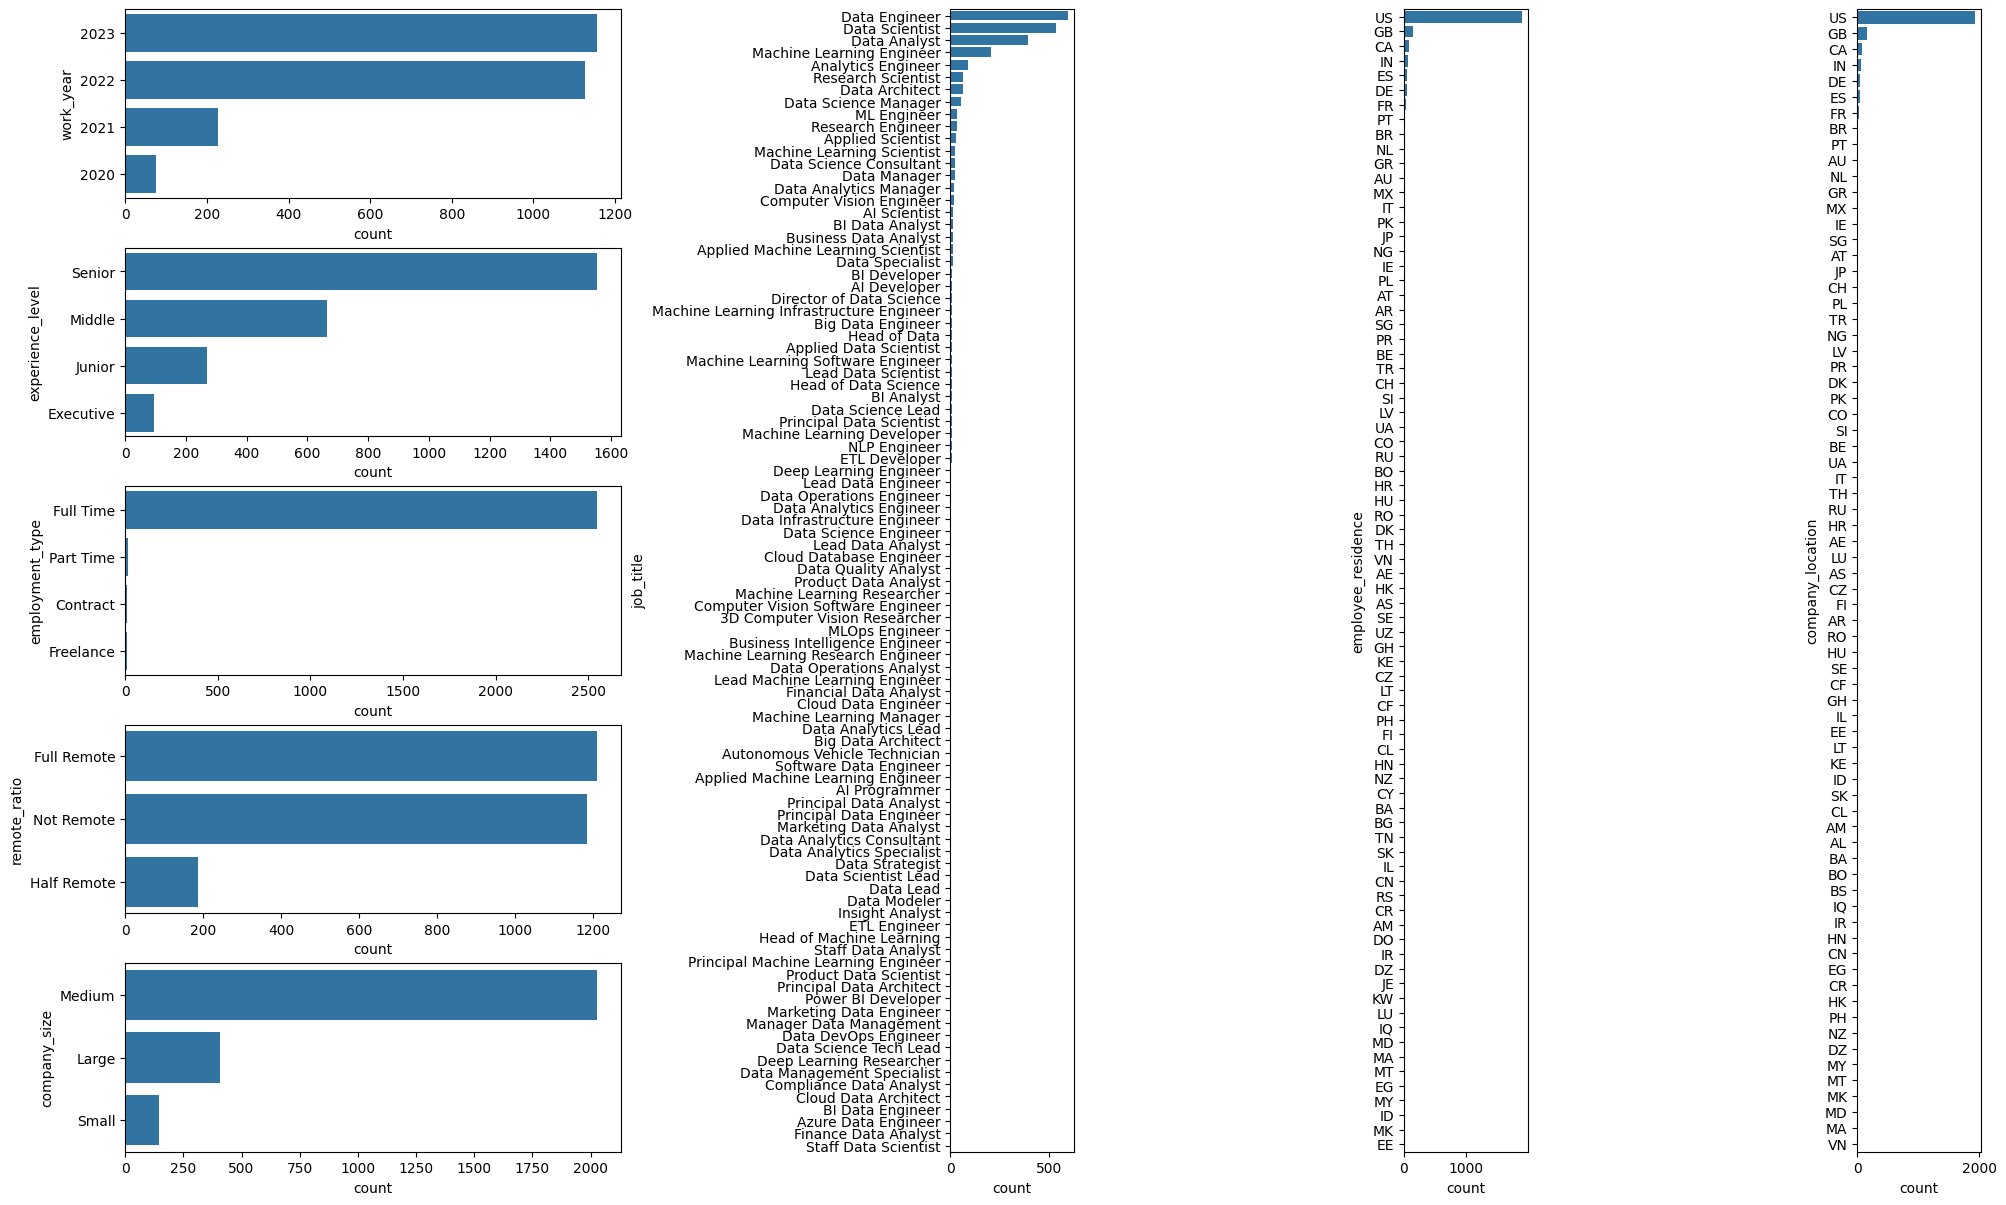

In [19]:
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(5, 4, width_ratios=(4,1,1,1))

create_plot(df3,'work_year',typ='count', ax = plt.subplot(gs[0, 0]), fig = fig)
create_plot(df3,'experience_level',typ='count', ax = plt.subplot(gs[1, 0]), fig = fig)
create_plot(df3,'employment_type',typ='count', ax = plt.subplot(gs[2, 0]), fig = fig)
create_plot(df3,'remote_ratio',typ='count', ax = plt.subplot(gs[3, 0]), fig = fig)
create_plot(df3,'company_size',typ='count', ax = plt.subplot(gs[4, 0]), fig = fig)


create_plot(df3, 'job_title', typ='count', ax=plt.subplot(gs[:, 1]), fig=fig)
create_plot(df3, 'employee_residence', typ='count', ax=plt.subplot(gs[:, 2]), fig=fig)
create_plot(df3, 'company_location', typ='count', ax=plt.subplot(gs[:, 3]), fig=fig)

plt.tight_layout(pad=0.5, w_pad=0.2)
plt.show()

In [45]:
req_job_titles = ['Data Engineer','Data Scientist','Data Analyst','Machine Learning Engineer','Analytics Engineer']
req_emp_residences = ['US','GB','CA','IN','ES']
req_company_locations = ['US','GB','CA','IN','DE']

df3['job_title'] = df3['job_title'].apply(lambda x : x if x in req_job_titles else 'Others')
df3['employee_residence'] = df3['employee_residence'].apply(lambda x : x if x in req_emp_residences else 'Others' )
df3['company_location'] = df3['company_location'].apply(lambda x : x if x in req_company_locations else 'Others' )
df3.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,Senior,Full Time,Others,85847,ES,Full Remote,Others,Large
1,2023,Middle,Contract,Others,30000,US,Full Remote,US,Small
2,2023,Middle,Contract,Others,25500,US,Full Remote,US,Small
3,2023,Senior,Full Time,Data Scientist,175000,CA,Full Remote,CA,Medium
4,2023,Senior,Full Time,Data Scientist,120000,CA,Full Remote,CA,Medium


In [48]:
# categorical variables
temp = pd.DataFrame(columns=['column1','column2','chi2 statistic','p_value', 'dof', 'expected_frequency', 'cramers_value'])

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k-1, r-1))))

l = 0
for i in range(len(cat_cols)):
    for j in range(i,len(cat_cols)):
        ct = pd.crosstab(df3[cat_cols[i]],df3[cat_cols[j]])
        stat, p_value, dof, exp_freq = chi2_contingency(ct)
        n = ct.sum().sum()
        r, k = ct.shape
        cramers_value = np.sqrt(stat / (n * (min(k-1, r-1))))
        temp.loc[l,:] = [cat_cols[i],cat_cols[j],stat, p_value, dof, exp_freq, cramers_value]
        l+=1
temp = temp[temp['cramers_value']!=1].sort_values(by='cramers_value', ascending=False)
temp

,column1,column2,chi2 statistic,p_value,dof,expected_frequency,cramers_value
28,employee_residence,company_location,9051.97035,0.0,25,"[[2.601780185758514, 1.7240712074303406, 4.858...",0.837029
7,work_year,company_size,687.85914,0.0,6,"[[11.871130030959753, 58.862229102167184, 4.26...",0.364828
29,employee_residence,company_size,572.933706,0.0,10,"[[12.820820433436532, 63.57120743034056, 4.607...",0.332959
5,work_year,remote_ratio,459.632965,0.0,6,"[[34.4233746130031, 5.427631578947368, 35.1489...",0.298225
34,company_location,company_size,445.634958,0.0,10,"[[13.137383900928793, 65.14086687306502, 4.721...",0.293649
27,employee_residence,remote_ratio,436.115793,0.0,10,"[[37.17724458204334, 5.8618421052631575, 37.96...",0.290496
32,remote_ratio,company_size,421.673646,0.0,4,"[[187.72213622291022, 930.8080495356037, 67.46...",0.285645
31,remote_ratio,company_location,409.008446,0.0,10,"[[38.095201238390096, 25.243808049535605, 71.1...",0.281323
11,experience_level,employee_residence,490.008462,0.0,15,"[[8.463622291021672, 4.9109907120743035, 15.67...",0.251417
13,experience_level,company_location,450.267672,0.0,15,"[[8.672600619195046, 5.746904024767802, 16.195...",0.241006


#### from above we can see that employee residence is highly associated with company location which in general is also True, so combine both into a single variable

In [53]:
df3['emp_residence_company_location'] = df3['employee_residence']+'_'+df3['company_location']
df3.drop(columns = ['employee_residence','company_location'],inplace=True)

In [55]:
df3.to_csv(artifacts / 'dataset.csv',index = False)